<a href="https://colab.research.google.com/github/Azeemahma/Reinforcement-Learning/blob/master/Pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 12.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(


Episode: 100, Epsilon: 0.95, Best Reward: [-6137.07131166], Mean Rewards -5858.9
Episode: 200, Epsilon: 0.90, Best Reward: -0.15201310889296352, Mean Rewards -6013.8
Episode: 300, Epsilon: 0.85, Best Reward: -1.0982789352570925, Mean Rewards -5915.2
Episode: 400, Epsilon: 0.80, Best Reward: -0.006985049203624604, Mean Rewards -5931.6
Episode: 500, Epsilon: 0.75, Best Reward: -0.006985049203624604, Mean Rewards -5773.6
Episode: 600, Epsilon: 0.70, Best Reward: -0.006985049203624604, Mean Rewards -5607.6
Episode: 700, Epsilon: 0.65, Best Reward: -0.006985049203624604, Mean Rewards -5382.1
Episode: 800, Epsilon: 0.60, Best Reward: -0.006985049203624604, Mean Rewards -5396.0
Episode: 900, Epsilon: 0.55, Best Reward: -0.006985049203624604, Mean Rewards -5017.0
Episode: 1000, Epsilon: 0.50, Best Reward: -0.006985049203624604, Mean Rewards -4687.8
Episode: 1100, Epsilon: 0.45, Best Reward: -0.006985049203624604, Mean Rewards -4462.3
Episode: 1200, Epsilon: 0.40, Best Reward: -0.00698504920362

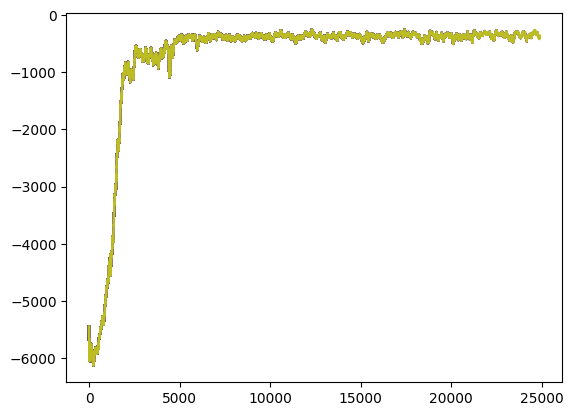

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(is_training=True, render=False):

    env = gym.make('Pendulum-v1', render_mode='human' if render else None)

    # hyperparameters
    learning_rate_a = 0.1        # alpha aka learning rate
    discount_factor_g = 0.9      # gamma aka discount factor.
    epsilon = 1                  # start episilon at 1 (100% random actions)
    epsilon_decay_rate = 0.0005  # epsilon decay rate
    epsilon_min = 0.05           # minimum epsilon
    divisions = 15               # used to convert continuous state space to discrete space

    # Divide observation space into discrete segments
    x  = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    y  = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    w  = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)

    # Divide action space into discrete segments
    a = np.linspace(env.action_space.low[0], env.action_space.high[0], divisions)

    if(is_training):
        # initialize q table to 16x16x16x16 array
        q = np.zeros((len(x)+1, len(y)+1, len(w)+1, len(a)+1))
    else:
        f = open('pendulum.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    best_reward = -99999
    rewards_per_episode = []     # list to store rewards for each episode
    num_episodes = 25000
    for i in range(num_episodes):


        state = env.reset()[0]      # Starting position, starting velocity always 0
        s_i0  = np.digitize(state[0], x)
        s_i1  = np.digitize(state[1], y)
        s_i2  = np.digitize(state[2], w)

        rewards = 0
        steps = 0

        # Episode
        while(steps < 1000 or is_training==False):

            if is_training and np.random.rand() < epsilon:
                # Choose random action
                action = env.action_space.sample()
                action_idx = np.digitize(action, a)
            else:
                action_idx = np.argmax(q[s_i0, s_i1, s_i2, :])
                action = a[action_idx-1]

            # Take action
            new_state,reward,_,_,_ = env.step([action])

            # Discretize new state
            ns_i0  = np.digitize(new_state[0], x)
            ns_i1  = np.digitize(new_state[1], y)
            ns_i2  = np.digitize(new_state[2], w)

            # Update Q table
            if is_training:
                q[s_i0, s_i1, s_i2, action_idx] = \
                    q[s_i0, s_i1, s_i2, action_idx] + \
                    learning_rate_a * (
                        reward + discount_factor_g*np.max(q[ns_i0, ns_i1, ns_i2,:])
                            - q[s_i0, s_i1, s_i2, action_idx]
                    )

            state = new_state
            s_i0 = ns_i0
            s_i1 = ns_i1
            s_i2 = ns_i2

            rewards += reward
            steps += 1

            if rewards>best_reward:
                best_reward = rewards

                # Save Q table to file on new best reward
                if is_training:
                    f = open('pendulum.pkl','wb')
                    pickle.dump(q, f)
                    f.close()


        # Store rewards per episode
        rewards_per_episode.append(rewards)

        # Print stats
        if is_training and i!=0 and i%100==0:
            mean_reward = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
            print(f'Episode: {i}, Epsilon: {epsilon:0.2f}, Best Reward: {best_reward}, Mean Rewards {mean_reward:0.1f}')

            # Graph mean rewards
            mean_rewards = []
            for t in range(i):
                mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
            plt.plot(mean_rewards)
            plt.savefig(f'pendulum.png')

        elif not is_training:
            print(f'Episode: {i} Best Reward: {reward:0.1f}')

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay_rate, epsilon_min)



        # THIS WHILE LOOP WILL NEVER END. MANUALLY STOP THE TRAINING WHEN THE SOLUTION IS FOUND.


if __name__ == '__main__':
    # run(is_training=True, render=False)

    run(is_training=True, render=False)
